# **PCB Detection and Classification**

### **Mount google drive and load data**
---

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [1]:
## Import all required libraries

import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Add, Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import GlobalMaxPool2D, MaxPooling2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import regularizers, optimizers

In [10]:
import os
os.chdir';';k**gdrive/My Drive/CV Assignment/Raw_PCB')
!ls

s_x_train.npy  s_y_train.npy  test.py


In [11]:
train_x = np.load('s_x_train.npy')
train_y = np.load('s_y_train.npy')
print(train_x.shape, train_y.shape)

(2669, 300, 300, 3) (2669,)


### ***Oversampling***

---



Since the dataset provided is highly imbalanced, we chose to oversample the minority class. The minority class is oversampled by applying the following transformations : flips, rotation by 90 and addition of noise. Since there should not be any overlap between train, test and valid even in terms of transformations, the defective samples are first split into all the three sets and then oversampled. 

In [12]:
## Dividing into defect and non-defect

from sklearn.model_selection import train_test_split

train_x_defect = train_x[0:148].copy()
train_y_defect = train_y[0:148].copy()

train_x_nondefect = train_x[149:].copy()
train_y_nondefect = train_y[149:].copy()

X_defect, testX_defect, Y_defect, testY_defect = train_test_split(train_x_defect, train_y_defect, test_size = 0.2, shuffle = True)
trainX_defect, valX_defect, trainY_defect, valY_defect = train_test_split(X_defect, Y_defect, test_size = 0.2, shuffle = True)

X_nondefect, testX_nondefect, Y_nondefect, testY_nondefect = train_test_split(train_x_nondefect, train_y_nondefect, test_size = 0.2, shuffle = True)
trainX_nondefect, valX_nondefect, trainY_nondefect, valY_nondefect = train_test_split(X_nondefect, Y_nondefect, test_size = 0.2, shuffle = True)

print(trainX_defect.shape, trainY_defect.shape)
print(valX_defect.shape,valY_defect.shape)
print(testX_defect.shape,testY_defect.shape)

print(trainX_nondefect.shape, trainY_nondefect.shape)
print(valX_nondefect.shape,valY_nondefect.shape)
print(testX_nondefect.shape,testY_nondefect.shape)


(94, 300, 300, 3) (94,)
(24, 300, 300, 3) (24,)
(30, 300, 300, 3) (30,)
(1612, 300, 300, 3) (1612,)
(404, 300, 300, 3) (404,)
(504, 300, 300, 3) (504,)


In [13]:
## Oversample only train and val

for i in range(len(valX_defect)):
  flip_v = np.flip(valX_defect[i],0)
  flip_h = np.flip(valX_defect[i],1)
  flip_v = np.expand_dims(flip_v,0)
  flip_h = np.expand_dims(flip_h,0)
  rot90_0 = np.rot90(valX_defect[i],0)
  rot90_1 = np.rot90(valX_defect[i], 1)
  rot90_0 = np.expand_dims(rot90_0, 0)
  rot90_1 = np.expand_dims(rot90_1, 0)
  noise = 0.7 * np.random.randn() + valX_defect[i]
  noise = np.clip(noise, 0, 255)
  noise = np.expand_dims(noise, 0)
  valX_defect = np.append(valX_defect, flip_v, axis=0)
  valX_defect = np.append(valX_defect, flip_h, axis=0)
  valX_defect = np.append(valX_defect, rot90_0, axis=0)
  valX_defect = np.append(valX_defect , rot90_1, axis=0)
  valX_defect = np.append(valX_defect, noise, axis = 0)
print(valX_defect.shape)

for i in range(len(trainX_defect)):
  flip_v = np.flip(trainX_defect[i],0)
  flip_h = np.flip(trainX_defect[i],1)
  flip_v = np.expand_dims(flip_v,0)
  flip_h = np.expand_dims(flip_h,0)
  rot90_0 = np.rot90(trainX_defect[i],0)
  rot90_1 = np.rot90(trainX_defect[i], 1)
  rot90_0 = np.expand_dims(rot90_0, 0)
  rot90_1 = np.expand_dims(rot90_1, 0)
  noise = 0.7 * np.random.randn() + trainX_defect[i]
  noise = np.clip(noise, 0, 255)
  noise = np.expand_dims(noise,0)
  trainX_defect = np.append(trainX_defect, flip_v, axis=0)
  trainX_defect = np.append(trainX_defect, flip_h, axis=0)
  trainX_defect = np.append(trainX_defect, rot90_0, axis=0)
  trainX_defect = np.append(trainX_defect , rot90_1, axis=0)
  trainX_defect = np.append(trainX_defect, noise, axis = 0)
print((trainX_defect.shape))

## The defective samples have label 0. So the label arrays are just zero arrays of shape the same shape as data arrays

trainY_defect = np.zeros(len(trainX_defect))
valY_defect = np.zeros(len(valX_defect))
print(trainY_defect.shape, valY_defect.shape)


(144, 300, 300, 3)
(564, 300, 300, 3)
(564,) (144,)


In [14]:
## Combine both defect and nondefect data into single arrays for train,validation and testing

trainX = np.concatenate((trainX_defect, trainX_nondefect), axis = 0)
trainY = np.concatenate((trainY_defect, trainY_nondefect), axis = 0)

valX = np.concatenate((valX_defect, valX_nondefect), axis = 0)
valY = np.concatenate((valY_defect, valY_nondefect), axis = 0)

testX = np.concatenate((testX_defect, testX_nondefect), axis = 0)
testY = np.concatenate((testY_defect, testY_nondefect), axis = 0)

print(trainX.shape, trainY.shape)
print(valX.shape, valY.shape)
print(testX.shape, testY.shape)

(2176, 300, 300, 3) (2176,)
(548, 300, 300, 3) (548,)
(534, 300, 300, 3) (534,)


### **Normalization**
---
The data should be normalized before sending into the model. \\
Since the image pixels have value in the range [0,255], all the arrays are divided by 255 inorder to maintain the range of values in [0,1].

In [0]:
trainX = trainX/255
valX = valX/255
testX = testX/255

### **Transfer learning**
We chose to solve this problem by transfer learning. We used inception as the pretrained model. \\
All the layers of the model are frozen except that of batch normalization layers. In order to prevent overfitting, we used L2 regularization in all the convolutional layers.

In [16]:
inception = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(300,300,3), pooling=max)
inception.summary()

87916544/87910968 [==============================] - 6s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
______________________

In [17]:
## The addition of layers to the last layer of inception base.

x = Flatten()(inception.layers[-1].output)
x = Dense(256, activation = 'relu')(x)
# x = Dropout(0.4)(x)
x = Dense(1, activation = 'sigmoid')(x)
model = Model(inputs = inception.input, outputs = x)

## Make all the layers of inception base non trainable
for layer in inception.layers:
  layer.trainable = False

##  All the batch normalization layers are made trainable in order to train the model to realise the mean of current inputs

for layer in model.layers:
  if "BatchNormalization" in layer.__class__.__name__:
    layer.trainable = True


## L2 regularizer is added to all the layers of the model
regularizer= keras.regularizers.l2(0.01)
for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

## The model has to be reloaded in order to reload the model config
model_json = model.to_json()
model.save_weights('../Colab Notebooks/imagenet.h5')
model = keras.models.model_from_json(model_json)
model.load_weights('../Colab Notebooks/imagenet.h5')

model.compile(optimizer= optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) , loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### **Training the Model**
----
The model is trained for 70 epochs. Early stopping with a patience of 15 epochs, ModelCheckpoint and ReduceLROnPlateau are added as callbacks. The model early stopped in all the runs.

In [0]:
print(len(model.trainable_weights))
mc = ModelCheckpoint('../Colab Notebooks/inception.h5',monitor='val_loss', save_best_only = True, verbose = 1, mode='min')
es = EarlyStopping(monitor='val_loss', mode = 'min',patience = 15, verbose=1)
lr = ReduceLROnPlateau(factor=0.1, patience = 5, min_lr = 0.0000001, verbose = 1)
history = model.fit(trainX, trainY, batch_size = 64, epochs = 70, validation_data=(valX,valY), shuffle = True, callbacks = [es,lr, mc])

98
Train on 2176 samples, validate on 548 samples
Epoch 1/70
2176/2176 [==============================] - 54s 25ms/step - loss: 119.4613 - accuracy: 0.8254 - val_loss: 119.2247 - val_accuracy: 0.7810

Epoch 00001: val_loss improved from inf to 119.22475, saving model to ../Colab Notebooks/inception.h5
Epoch 2/70
2176/2176 [==============================] - 25s 12ms/step - loss: 118.4690 - accuracy: 0.9660 - val_loss: 118.9367 - val_accuracy: 0.7956

Epoch 00002: val_loss improved from 119.22475 to 118.93675, saving model to ../Colab Notebooks/inception.h5
Epoch 3/70
2176/2176 [==============================] - 26s 12ms/step - loss: 117.8479 - accuracy: 0.9931 - val_loss: 118.7641 - val_accuracy: 0.7774

Epoch 00003: val_loss improved from 118.93675 to 118.76405, saving model to ../Colab Notebooks/inception.h5
Epoch 4/70
2176/2176 [==============================] - 25s 12ms/step - loss: 117.3412 - accuracy: 0.9977 - val_loss: 117.6846 - val_accuracy: 0.8303

Epoch 00004: val_loss improv

### **Accuracy Graphs**
---

<Figure size 432x288 with 0 Axes>

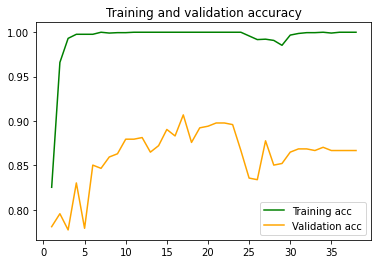

<Figure size 432x288 with 0 Axes>

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)
plt.plot(epochs,acc, 'b', color='green', label = 'Training acc')
plt.plot(epochs,val_acc, 'b', color='orange', label = 'Validation acc')

plt.title('Training and validation accuracy')

plt.legend()

plt.figure()

### **Loss graph**
---
The model converges. The best weights are stored which are used for evaluation.

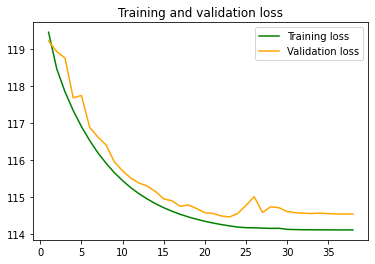

In [0]:
plt.plot(epochs, loss, 'b', color='green', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', color='orange', label = 'Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

### **Evaluation**
---
The best weights are loaded for evaluation. \\
The confusion matrix is calculated and the following measures are evaluated. \\
Defective accuracy = TN / (TN + FP) \\
Nondefective accuracy = TP / (TP + FN) \\

Defective precision = TN / (TN + FN) \\
Nondefective precision =  TP /(TP + FP) \\
Defective recall = TN / (TN + FP) \\
Nondefective recall = TP / (TP + FN) \\
where TP denotes number of *True Positives*, TN denotes number of *True Negatives*, FP denotes number *False Positives* and FN denotes number of *False Negatives*.

In [18]:
## A function for evaluation and printing of confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report

def evaluation(X,Y, model, threshold, weights_path):
  model.load_weights(weights_path)
  pred = model.predict(X)
  print(model.evaluate(X,Y))

  ## Binarise predictions 
  pred[pred >= threshold] = 1
  pred[pred < threshold ] = 0

  ## Display defective and non defective accuracies
  
  tn, fp, fn, tp = confusion_matrix(Y, pred).ravel()
  defective_accuracy = tn/(tn+fp)
  nondefective_accuracy = tp/(tp + fn)

  precision_nondefective = tp/(tp+fp)
  recall_nondefective = tp/(tp + fn)

  precision_defective = tn/(tn+fn)
  recall_defective = tn/(tn+fp)
  print('---------------------------------------------------------------------------------------------------------------------------')
  print('\nDefective Accuracy:' +  str(defective_accuracy),'\nNondefective Accuracy:' + str(nondefective_accuracy))
  print('\nDefective precision:' + str(precision_defective), '\nNondefective precision:' +  str(precision_nondefective))
  print('\nDefective Recall:' + str(recall_defective), '\nNondefective recall:'+ str(recall_nondefective))
  print('---------------------------------------------------------------------------------------------------------------------------')

  ## Display confusion matrix
  data = confusion_matrix(Y,pred)
  df = pd.DataFrame(data, columns = ['Defect','Non-defect'], index = ['Defect','Non-defect'])
  df.index.name = 'Actual'
  df.columns.name = 'Predicted'
  plt.figure(figsize = (10,7))
  sns.set(font_scale = 1.4)
  sns.heatmap(df, cmap = 'Blues', annot = True, fmt = "d")

  print("\n--------------- CLASSIFICATION REPORT ---------------\n")
  print(classification_report(Y, pred, target_names=['Defect','Non-defect'], digits = 5))
  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_x = train_x/255
balanced_x = np.load('../Balanced_PCB/xtrain.npy')
balanced_y = np.load('../Balanced_PCB/ytrain.npy')

balanced_x = balanced_x /255

534/534 [==============================] - 10s 18ms/step
[114.24489273471332, 0.9812734127044678]
---------------------------------------------------------------------------------------------------------------------------

Defective Accuracy:0.8333333333333334 
Nondefective Accuracy:0.9900793650793651

Defective precision:0.8333333333333334 
Nondefective precision:0.9900793650793651

Defective Recall:0.8333333333333334 
Nondefective recall:0.9900793650793651
---------------------------------------------------------------------------------------------------------------------------

--------------- CLASSIFICATION REPORT ---------------

              precision    recall  f1-score   support

      Defect    0.83333   0.83333   0.83333        30
  Non-defect    0.99008   0.99008   0.99008       504

    accuracy                        0.98127       534
   macro avg    0.91171   0.91171   0.91171       534
weighted avg    0.98127   0.98127   0.98127       534



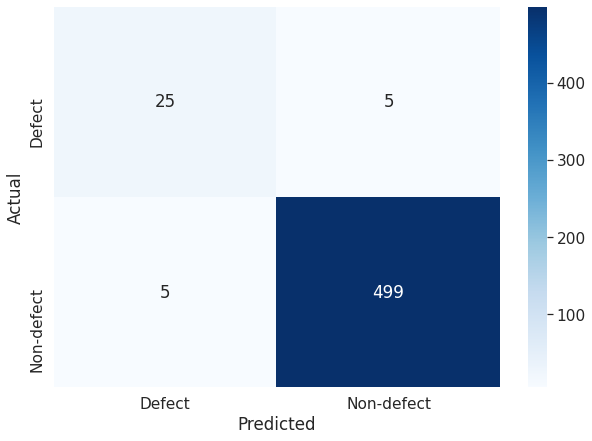

In [0]:
## For the model with the last saved weights to evaluate on test data
threshold = 0.5
weights_path = '../Colab Notebooks/inception.h5'
evaluation(testX,testY,model,threshold,weights_path)

2669/2669 [==============================] - 36s 13ms/step
[114.23796179018561, 0.9820157289505005]
---------------------------------------------------------------------------------------------------------------------------

Defective Accuracy:0.8590604026845637 
Nondefective Accuracy:0.9892857142857143

Defective precision:0.8258064516129032 
Nondefective precision:0.9916467780429594

Defective Recall:0.8590604026845637 
Nondefective recall:0.9892857142857143
---------------------------------------------------------------------------------------------------------------------------

--------------- CLASSIFICATION REPORT ---------------

              precision    recall  f1-score   support

      Defect    0.82581   0.85906   0.84211       149
  Non-defect    0.99165   0.98929   0.99046      2520

    accuracy                        0.98202      2669
   macro avg    0.90873   0.92417   0.91629      2669
weighted avg    0.98239   0.98202   0.98218      2669



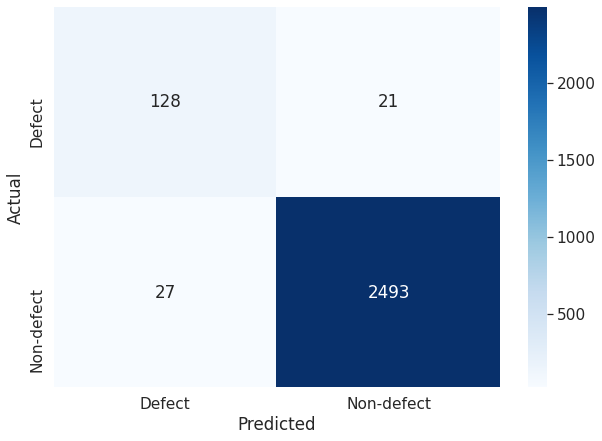

In [0]:
## For the model with the last saved weights to evaluate on entire raw data
threshold = 0.5
weights_path = '../Colab Notebooks/inception.h5'

evaluation(train_x,train_y,model,threshold,weights_path)

298/298 [==============================] - 4s 14ms/step
[114.3742332714516, 0.926174521446228]
---------------------------------------------------------------------------------------------------------------------------

Defective Accuracy:0.8590604026845637 
Nondefective Accuracy:0.9932885906040269

Defective precision:0.9922480620155039 
Nondefective precision:0.8757396449704142

Defective Recall:0.8590604026845637 
Nondefective recall:0.9932885906040269
---------------------------------------------------------------------------------------------------------------------------

--------------- CLASSIFICATION REPORT ---------------

              precision    recall  f1-score   support

      Defect    0.99225   0.85906   0.92086       149
  Non-defect    0.87574   0.99329   0.93082       149

    accuracy                        0.92617       298
   macro avg    0.93399   0.92617   0.92584       298
weighted avg    0.93399   0.92617   0.92584       298



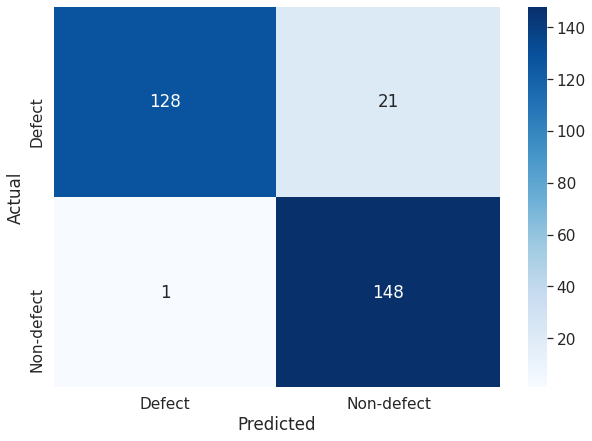

In [0]:
## For the model with the last saved weights to evaluate on balanced data

threshold = 0.5
weights_path = '../Colab Notebooks/inception.h5'
evaluation(balanced_x,balanced_y,model,threshold,weights_path)

### **Best results achieved so far**

In [0]:
new_model = load_model('../Colab Notebooks/inception_goodweights.h5')

534/534 [==============================] - 10s 18ms/step
[114.05184633633617, 0.9794007539749146]
---------------------------------------------------------------------------------------------------------------------------

Defective Accuracy:0.8666666666666667 
Nondefective Accuracy:0.9861111111111112

Defective precision:0.7878787878787878 
Nondefective precision:0.9920159680638723

Defective Recall:0.8666666666666667 
Nondefective recall:0.9861111111111112
---------------------------------------------------------------------------------------------------------------------------

--------------- CLASSIFICATION REPORT ---------------

              precision    recall  f1-score   support

      Defect    0.78788   0.86667   0.82540        30
  Non-defect    0.99202   0.98611   0.98905       504

    accuracy                        0.97940       534
   macro avg    0.88995   0.92639   0.90723       534
weighted avg    0.98055   0.97940   0.97986       534



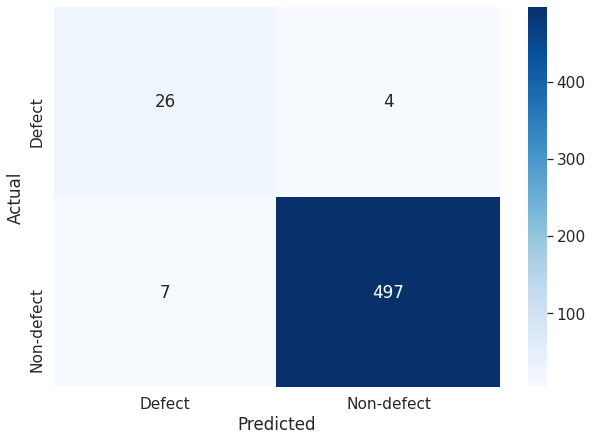

In [0]:

threshold = 0.5
weights_path = '../Colab Notebooks/inception_goodweights.h5'
evaluation(testX,testY,new_model, threshold, weights_path)

2669/2669 [==============================] - 36s 14ms/step
[114.03455817292986, 0.9850131273269653]
---------------------------------------------------------------------------------------------------------------------------

Defective Accuracy:0.8657718120805369 
Nondefective Accuracy:0.9920634920634921

Defective precision:0.8657718120805369 
Nondefective precision:0.9920634920634921

Defective Recall:0.8657718120805369 
Nondefective recall:0.9920634920634921
---------------------------------------------------------------------------------------------------------------------------

--------------- CLASSIFICATION REPORT ---------------

              precision    recall  f1-score   support

      Defect    0.86577   0.86577   0.86577       149
  Non-defect    0.99206   0.99206   0.99206      2520

    accuracy                        0.98501      2669
   macro avg    0.92892   0.92892   0.92892      2669
weighted avg    0.98501   0.98501   0.98501      2669



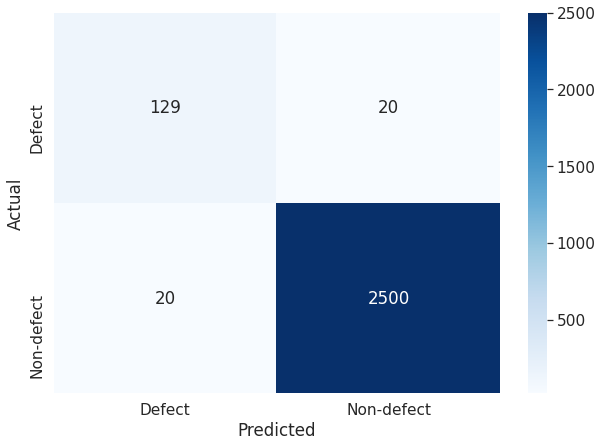

In [0]:
threshold = 0.5
weights_path = '../Colab Notebooks/inception_goodweights.h5'
evaluation(train_x,train_y,new_model, threshold, weights_path)

298/298 [==============================] - 4s 14ms/step
[114.23022932014209, 0.926174521446228]
---------------------------------------------------------------------------------------------------------------------------

Defective Accuracy:0.8657718120805369 
Nondefective Accuracy:0.9865771812080537

Defective precision:0.9847328244274809 
Nondefective precision:0.8802395209580839

Defective Recall:0.8657718120805369 
Nondefective recall:0.9865771812080537
---------------------------------------------------------------------------------------------------------------------------

--------------- CLASSIFICATION REPORT ---------------

              precision    recall  f1-score   support

      Defect    0.98473   0.86577   0.92143       149
  Non-defect    0.88024   0.98658   0.93038       149

    accuracy                        0.92617       298
   macro avg    0.93249   0.92617   0.92590       298
weighted avg    0.93249   0.92617   0.92590       298



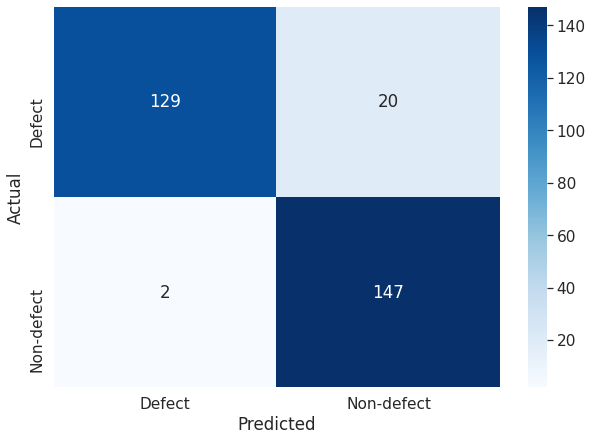

In [0]:
threshold = 0.5
weights_path = '../Colab Notebooks/inception_goodweights.h5'
evaluation(balanced_x,balanced_y,new_model, threshold, weights_path)

### **Some visualisations**
---

In [0]:
## Get the indices of the data where there are false positives and false neagtives
pred_test = new_model.predict(testX)

threshold = 0.5
pred_test[pred_test >= threshold] = 1
pred_test[pred_test < threshold] = 0


In [0]:
# print(train_y.shape, pred_train.shape)
pred_flatten = pred_test.flatten()
d = np.isclose(testY,pred_flatten)
# print(np.isclose(train_y,pred_flatten))
mismatches = np.where(d == False)[0]
matches = np.where(d == True)[0]

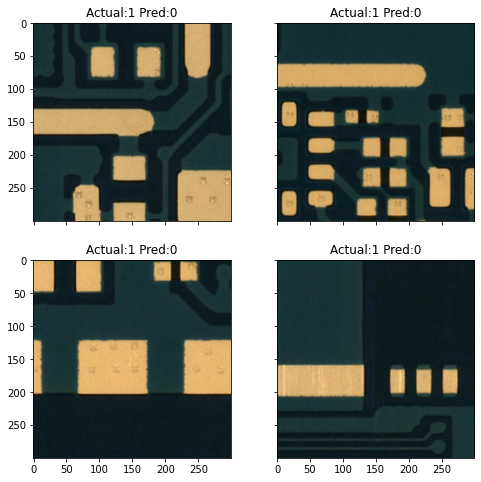

In [35]:
## Display mismatches

import matplotlib.pyplot as plt

columns = 2
rows = 2

fig, axs = plt.subplots(nrows = rows, ncols=columns, figsize =  (8,8), sharex='col', sharey='row')
for i,ax in enumerate(axs.flat) :
    ax.imshow(testX[mismatches[i+5]])
    ax.set_title("Actual:"+ str(int(testY[mismatches[i+5]])) + " Pred:" + str(int(pred_test[mismatches[i+5]])))
    ax.grid(False, which='both')
plt.show()

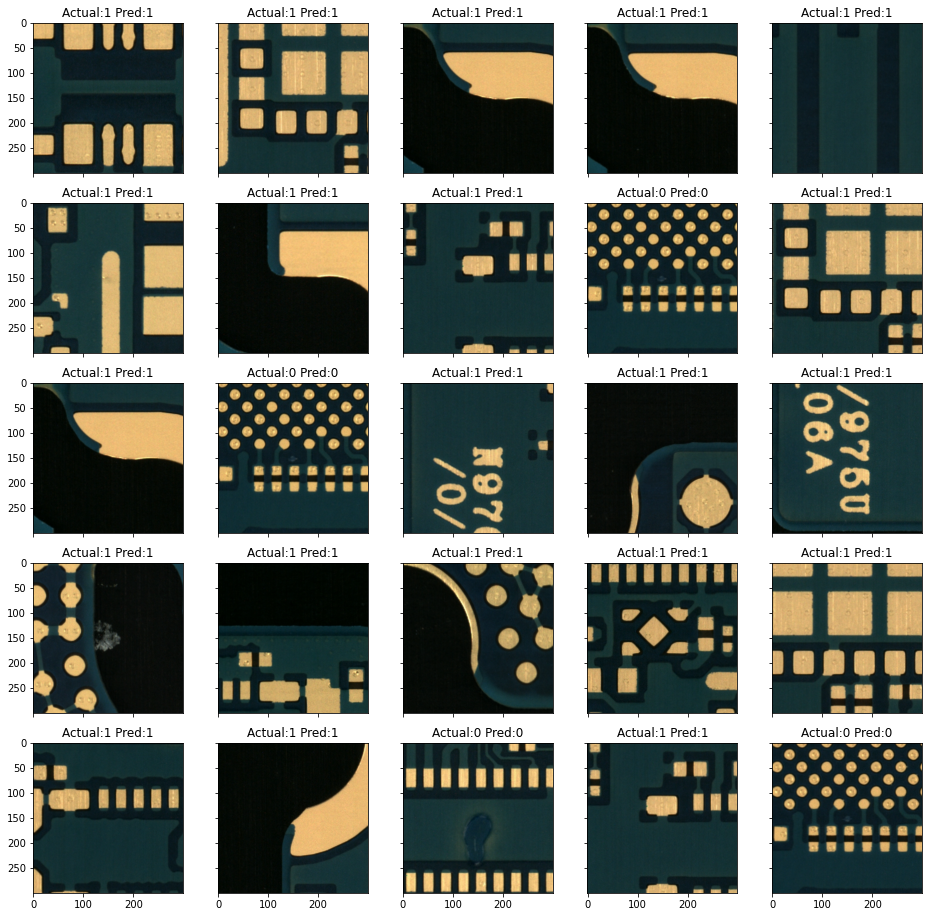

In [31]:
## Displaying True positives
import matplotlib.pyplot as plt
import random
columns = 5
rows = 5

fig, axs = plt.subplots(nrows = rows, ncols=columns, figsize =  (16,16), sharex='col', sharey='row')
for i,ax in enumerate(axs.flat) :
    j = random.choice(matches)
    ax.imshow(testX[j])
    ax.set_title("Actual:"+ str(int(testY[j])) + " Pred:" + str(int(pred_test[j])))
    ax.grid(False, which='both')
plt.show()

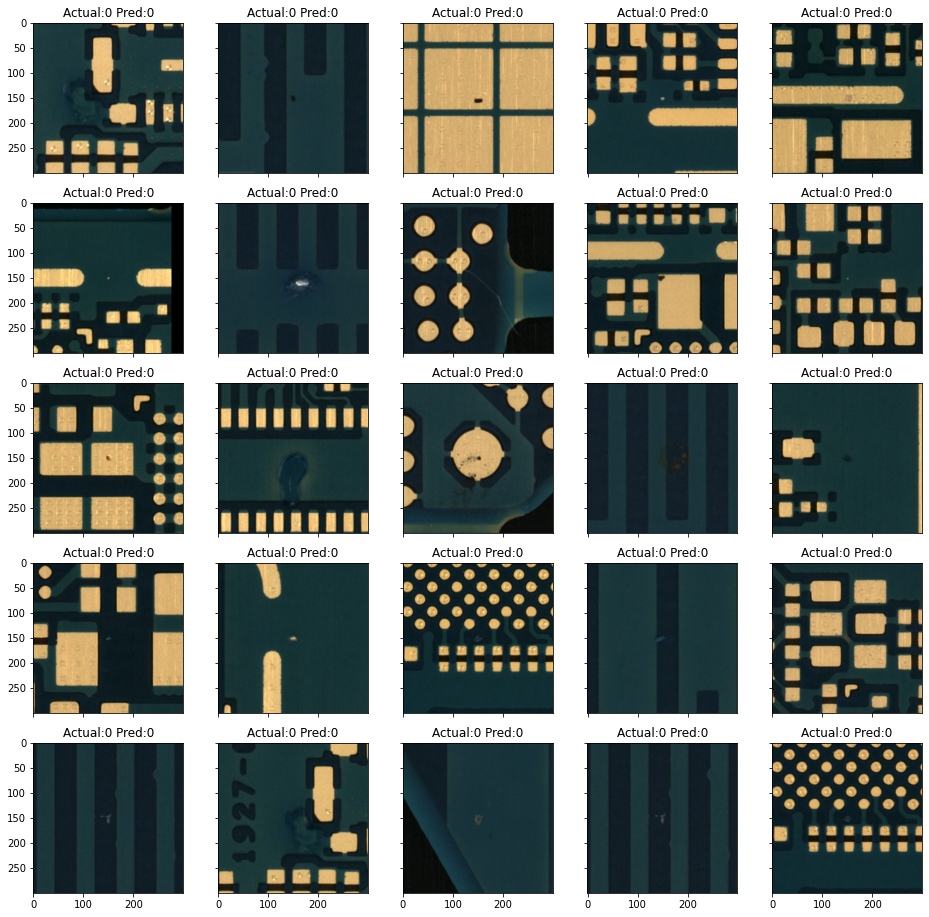

In [32]:
## Displaying True negatives
import matplotlib.pyplot as plt
import random
columns = 5
rows = 5

fig, axs = plt.subplots(nrows = rows, ncols=columns, figsize =  (16,16), sharex='col', sharey='row')
for i,ax in enumerate(axs.flat) :
    j = matches[i]
    ax.imshow(testX[j])
    ax.set_title("Actual:"+ str(int(testY[j])) + " Pred:" + str(int(pred_test[j])))
    ax.grid(False, which='both')
plt.show()

# **END OF NOTEBOOK**

---


